In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stat
import seaborn as sns
import scipy
from scipy.integrate import quad
from scipy.special import binom
import statsmodels.api as sm
import pylab

## Data Extraction

In [95]:
def create_dataframe():
    return pd.read_csv('hour.csv')
def df_wrapper():
    """
    
    """
    df = create_dataframe()
    df = df[df['holiday'] != 1 ]
    df = df[df['workingday'] == 1]

    #df = df[df['yr'] == 1]
    

    df = df[df['hr'].isin(np.arange(16,19))]
    df_spring = df[df['season'] == 2]
    df_summer = df[df['season'] == 3]

    return pd.concat([df_spring, df_summer])
    
def season_wrapper(df):
    """
    
    """
    df = df_wrapper()
    df_spring = df[df['season'] == 2]
    df_summer = df[df['season'] == 3]

    return df_spring, df_summer

def count_aggregator(df_hr):
    """ 
    
    """
    return df_hr['cnt'].groupby(df_hr['dteday']).sum()
 

def collect_data(df):
    """ 
    
    """
    df_spring, df_summer = season_wrapper(df)
    
    frames = {}
    frames['spring'], frames['summer'] = df_spring, df_summer
  
    for key in frames.keys():
        frames[key] = count_aggregator(frames[key])
    
    return frames
df_agg = df_wrapper()
df_agg


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1822,1823,2011-03-21,2,0,3,16,0,1,1,2,0.54,0.5152,0.64,0.2836,29,112,141
1823,1824,2011-03-21,2,0,3,17,0,1,1,2,0.54,0.5152,0.64,0.2537,41,231,272
1824,1825,2011-03-21,2,0,3,18,0,1,1,2,0.52,0.5000,0.72,0.2239,44,232,276
1846,1847,2011-03-22,2,0,3,16,0,2,1,1,0.50,0.4848,0.42,0.1045,40,125,165
1847,1848,2011-03-22,2,0,3,17,0,2,1,1,0.50,0.4848,0.42,0.1045,42,265,307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964,14965,2012-09-20,3,1,9,17,0,4,1,1,0.64,0.6212,0.50,0.2239,91,885,976
14965,14966,2012-09-20,3,1,9,18,0,4,1,1,0.60,0.6212,0.56,0.2537,119,781,900
14987,14988,2012-09-21,3,1,9,16,0,5,1,1,0.70,0.6515,0.54,0.1940,103,464,567
14988,14989,2012-09-21,3,1,9,17,0,5,1,1,0.68,0.6364,0.57,0.2836,107,739,846


In [96]:
for col in df_agg.columns:
    print(f"{col} has NaN? ", df_agg[col].isnull().values.any())

instant has NaN?  False
dteday has NaN?  False
season has NaN?  False
yr has NaN?  False
mnth has NaN?  False
hr has NaN?  False
holiday has NaN?  False
weekday has NaN?  False
workingday has NaN?  False
weathersit has NaN?  False
temp has NaN?  False
atemp has NaN?  False
hum has NaN?  False
windspeed has NaN?  False
casual has NaN?  False
registered has NaN?  False
cnt has NaN?  False


In [97]:
def generate_quartiles(df):
    arr = np.zeros(df.shape[0])
    store_quartiles = {'windspeed' : arr, 'hum' : arr, 'weathersit' : arr, 'atemp' : arr}

    for feat in store_quartiles.keys():
        quartiles = np.ones(df.shape[0])
        for q in [25,50,75]:
            quartiles += np.where(df[str(feat)] > np.percentile(df[str(feat)], q), 1, 0)
        
        df[f"{feat}_code"] = quartiles
    
    return df

def outlier_detection(df):
    df = generate_quartiles(df)
    fig = plt.figure(figsize= (15,10))
    plt.title('Count vs Quartiles for Continuous Weather Data', fontweight = 'bold', fontsize=15)
    for idx, x in zip(range(221,225), ['weathersit_code', 'windspeed_code', 'hum_code', 'atemp_code']):
        ax1 = fig.add_subplot(idx)
        df = df.replace([2,3], ['Summer', 'Spring'])
        sns.boxplot(x=x, y='cnt', data=df, hue='yr')
    
    plt.show()

def inspect_hourly_means(df):
    for hr in np.unique(df['hr']):
    
        test = df[df['hr'] == hr]
        test = test[test['yr'] == 1]
        test = test[test['hr'] == hr]
        test_spring = test[test['season']==2]
        test_summer = test[test['season']==3]
        print(f"Spring: Mean(hr = {hr}) = {round(np.mean(test_spring['cnt']),2)}")
        print(f"Summer: Mean(hr = {hr}) = {round(np.mean(test_summer['cnt']),2)}\n")



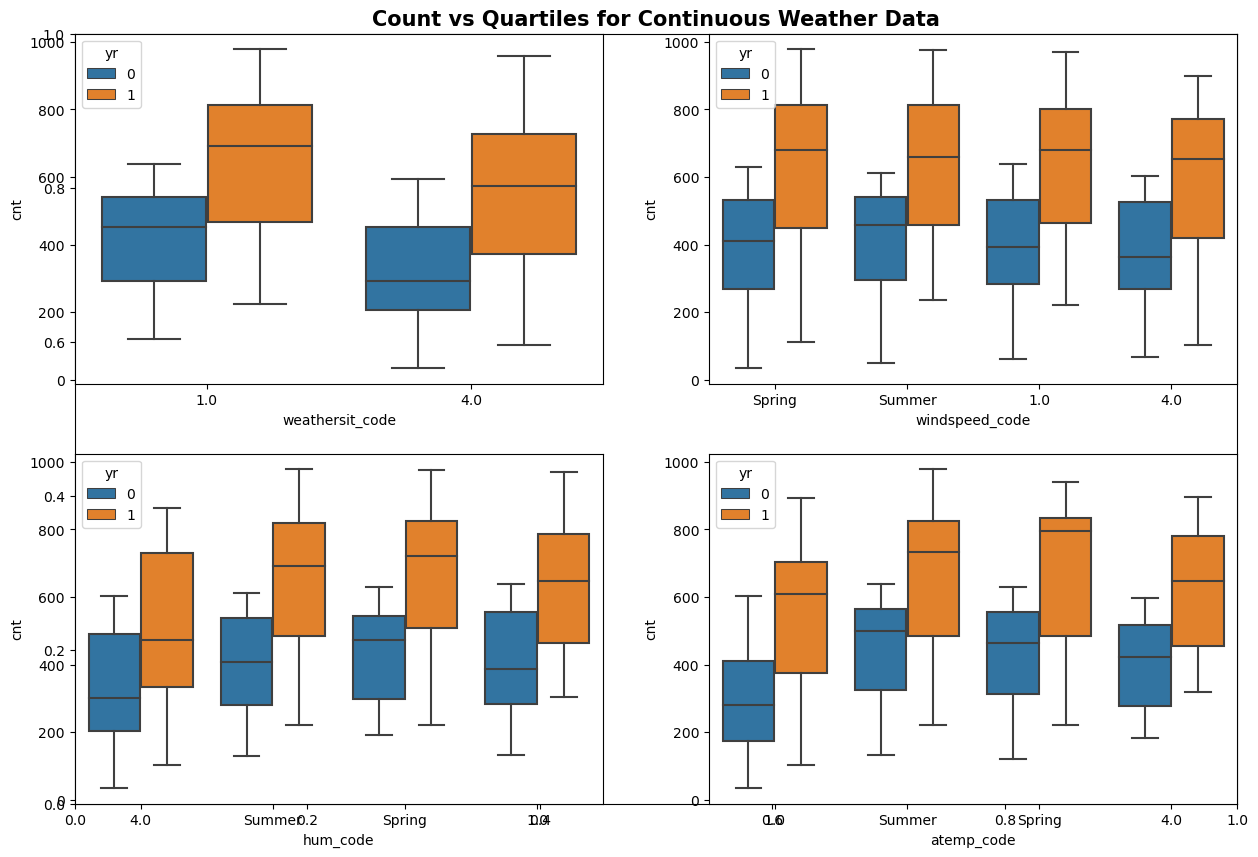

In [98]:
outlier_detection(df_agg)

In [99]:
df_agg

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,atemp,hum,windspeed,casual,registered,cnt,windspeed_code,hum_code,weathersit_code,atemp_code
1822,1823,2011-03-21,2,0,3,16,0,1,1,2,...,0.5152,0.64,0.2836,29,112,141,3.0,4.0,4.0,1.0
1823,1824,2011-03-21,2,0,3,17,0,1,1,2,...,0.5152,0.64,0.2537,41,231,272,3.0,4.0,4.0,1.0
1824,1825,2011-03-21,2,0,3,18,0,1,1,2,...,0.5000,0.72,0.2239,44,232,276,2.0,4.0,4.0,1.0
1846,1847,2011-03-22,2,0,3,16,0,2,1,1,...,0.4848,0.42,0.1045,40,125,165,1.0,2.0,1.0,1.0
1847,1848,2011-03-22,2,0,3,17,0,2,1,1,...,0.4848,0.42,0.1045,42,265,307,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14964,14965,2012-09-20,3,1,9,17,0,4,1,1,...,0.6212,0.50,0.2239,91,885,976,2.0,3.0,1.0,2.0
14965,14966,2012-09-20,3,1,9,18,0,4,1,1,...,0.6212,0.56,0.2537,119,781,900,3.0,3.0,1.0,2.0
14987,14988,2012-09-21,3,1,9,16,0,5,1,1,...,0.6515,0.54,0.1940,103,464,567,2.0,3.0,1.0,2.0
14988,14989,2012-09-21,3,1,9,17,0,5,1,1,...,0.6364,0.57,0.2836,107,739,846,3.0,3.0,1.0,2.0


In [100]:
inspect_hourly_means(df_agg)

Spring: Mean(hr = 16) = 390.47
Summer: Mean(hr = 16) = 438.8

Spring: Mean(hr = 17) = 705.66
Summer: Mean(hr = 17) = 796.66

Spring: Mean(hr = 18) = 674.5
Summer: Mean(hr = 18) = 764.95



In [101]:
df2 = df_agg[df_agg['hr'] == 16]
        
spring = count_aggregator(df2[df2['season'] == 2])
summer = count_aggregator(df2[df2['season'] == 3])


kde_spring = scipy.stats.gaussian_kde(spring)
kde_spring.evaluate(spring)

array([0.00122337, 0.001399  , 0.00118861, 0.00078352, 0.00128649,
       0.00116065, 0.00118861, 0.00037419, 0.00079219, 0.00141521,
       0.0016236 , 0.00114657, 0.00143179, 0.00193525, 0.00057287,
       0.00230599, 0.00091072, 0.00123032, 0.00178009, 0.00182029,
       0.00165724, 0.00268567, 0.00328422, 0.00059032, 0.00238032,
       0.00325418, 0.00201279, 0.00295884, 0.00332659, 0.00294174,
       0.00297572, 0.00169234, 0.00294174, 0.00330743, 0.00335921,
       0.00338966, 0.00323229, 0.00322079, 0.0033339 , 0.00214551,
       0.00324342, 0.00328422, 0.00334734, 0.00338074, 0.00310185,
       0.00307194, 0.00332659, 0.00325418, 0.00224481, 0.0025708 ,
       0.00288926, 0.00339977, 0.00327001, 0.00290694, 0.0033783 ,
       0.00226945, 0.00175416, 0.00318417, 0.00339205, 0.00338074,
       0.00339128, 0.00328422, 0.00321809, 0.00332659, 0.00295203,
       0.00212594, 0.00042443, 0.00336456, 0.00336456, 0.00206135,
       0.00280408, 0.00309235, 0.00268964, 0.00106461, 0.00277

# Plotting Functions for Comparing Distributions

In [ ]:
# Seaborn palletes:
#  'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r',
# 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 
# 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 
# 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 
# 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 
# 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 
# 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', '
# YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 
# 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest',
#  'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
# 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
# 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot',
#  'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 
# 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r',
#  'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 
# 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 
# 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [250]:
from seaborn_qqplot import pplot
from sklearn import metrics
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats

def plot_hist_kde(df):
    """ 
    
    """
    fig, ax = plt.subplots(1,4, figsize=(25,5))
    i = 0
    for hr in np.unique(df['hr']):
        df2 = df[df['hr'] == hr]
        
        spring = count_aggregator(df2[df2['season'] == 2])
        summer = count_aggregator(df2[df2['season'] == 3])
        
        kde_spring = scipy.stats.gaussian_kde(spring)
        kde_spring = kde_spring.evaluate(spring)
        kde_summer = scipy.stats.gaussian_kde(summer)
        kde_summer = kde_summer.evaluate(summer)
        

        ax[i].hist(x=spring, color='red', label='Spring', alpha=0.3, bins=20, density=True)
        ax[i].hist(x=summer, color='blue', label='Summer', alpha=0.3, bins=20, density=True)
        ax[i].scatter(spring,kde_spring, color='red',label='kde spring', marker='o')
        ax[i].scatter(summer,kde_summer, color='blue', label='kde summer', marker='^')
      
        ax[i].set_title(f'{hr}:00-{hr}:59')
        ax[i].set_xlabel('cnt')
        ax[i].set_ylabel('$p(cnt)$')


        i += 1
    spring = df[df['season'] == 2]
    summer = df[df['season'] == 3]

    spring = spring['cnt']
    summer = summer['cnt']
    
    kde_spring = scipy.stats.gaussian_kde(spring)
    kde_spring = kde_spring.evaluate(spring)
    kde_summer = scipy.stats.gaussian_kde(summer)
    kde_summer = kde_summer.evaluate(summer)
    
    ax[i].hist(x=spring, color='red', label='Spring', alpha=0.3, bins=40, density=True)
    ax[i].hist(x=summer, color='blue', label='Summer', alpha=0.3, bins=40, density=True)
    ax[i].scatter(spring,kde_spring, color='red',label='kde spring', marker='o')
    ax[i].scatter(summer,kde_summer, color='blue', label='kde summer', marker='^')
    ax[i].set_title('Collected Hours')
    ax[i].set_xlabel('cnt')
    ax[i].set_ylabel('$p(cnt)$')
    
    plt.legend()
    plt.suptitle('Summer vs. Spring Bike Rental Distribution', fontweight='bold', fontsize=15)
    plt.tight_layout()
    plt.show()

    sns.set(rc={'figure.figsize':(5,8)})
    sns.displot(data=df, x='cnt', hue='season', kde=True, palette='Set2')
    
    
def plot_line(df):
    df = df.replace([2,3], ['Summer', 'Spring'])
    sns.lineplot(x='hr',y='cnt', data=df, palette = 'tab10', hue='season')
    plt.title("Season Counts");

def plot_box(df):
    """ 
    
    """
    # / TODO improve plotting
    df = df.replace([2,3], ['Summer', 'Spring'])
    sns.boxplot(data=df, x='hr', y='cnt', hue='season')
    
def plot_qq(df):
    """ 
    
    """
    df = df.replace([2,3], ['Summer', 'Spring'])
    pplot(data=df, x='hr', y='cnt', hue='season', kind='qq', height=4, aspect=2, display_kws={"identity":False})

def mean_squared_error(sample1, sample2):
    """  
    
    """
    assert(len(sample1) == len(sample2))
    return round(np.sum( (1/len(sample1))*(sample1 - sample2)**2),5)

def plot_ecdf(df):
   
    
    cnt_spring = df[df['season'] == 2]
    cnt_summer = df[df['season'] == 3]
    spring = ECDF(cnt_spring['cnt'])
    summer = ECDF(cnt_summer['cnt'])
    
    plt.plot(spring.x, spring.y, color='blue', label='ECDF spring')
    plt.plot(summer.x, summer.y, color='red', label='ECDF summer')
    
    plt.suptitle('Empirical Cumulative Distribution Function', fontweight='bold', fontsize=15)
    plt.legend()
    plt.show()

# Visuals for Comparing Distributions

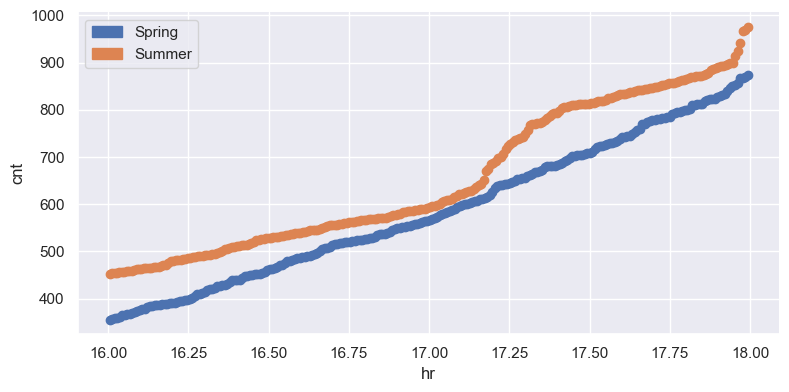

In [251]:
plot_qq(df_agg)

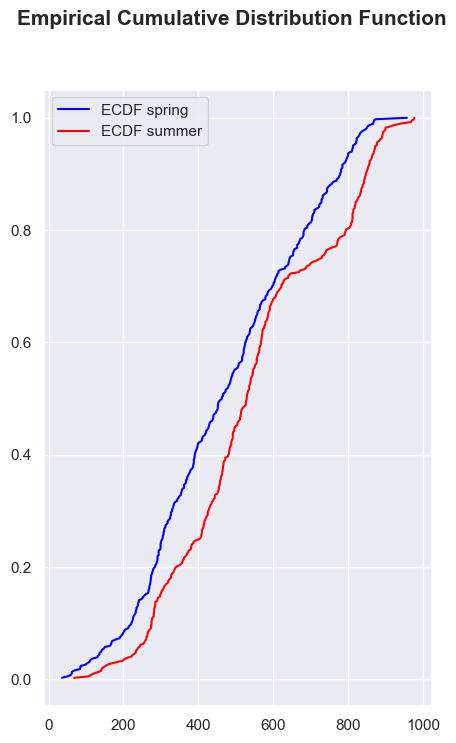

In [252]:
plot_ecdf(df_agg)

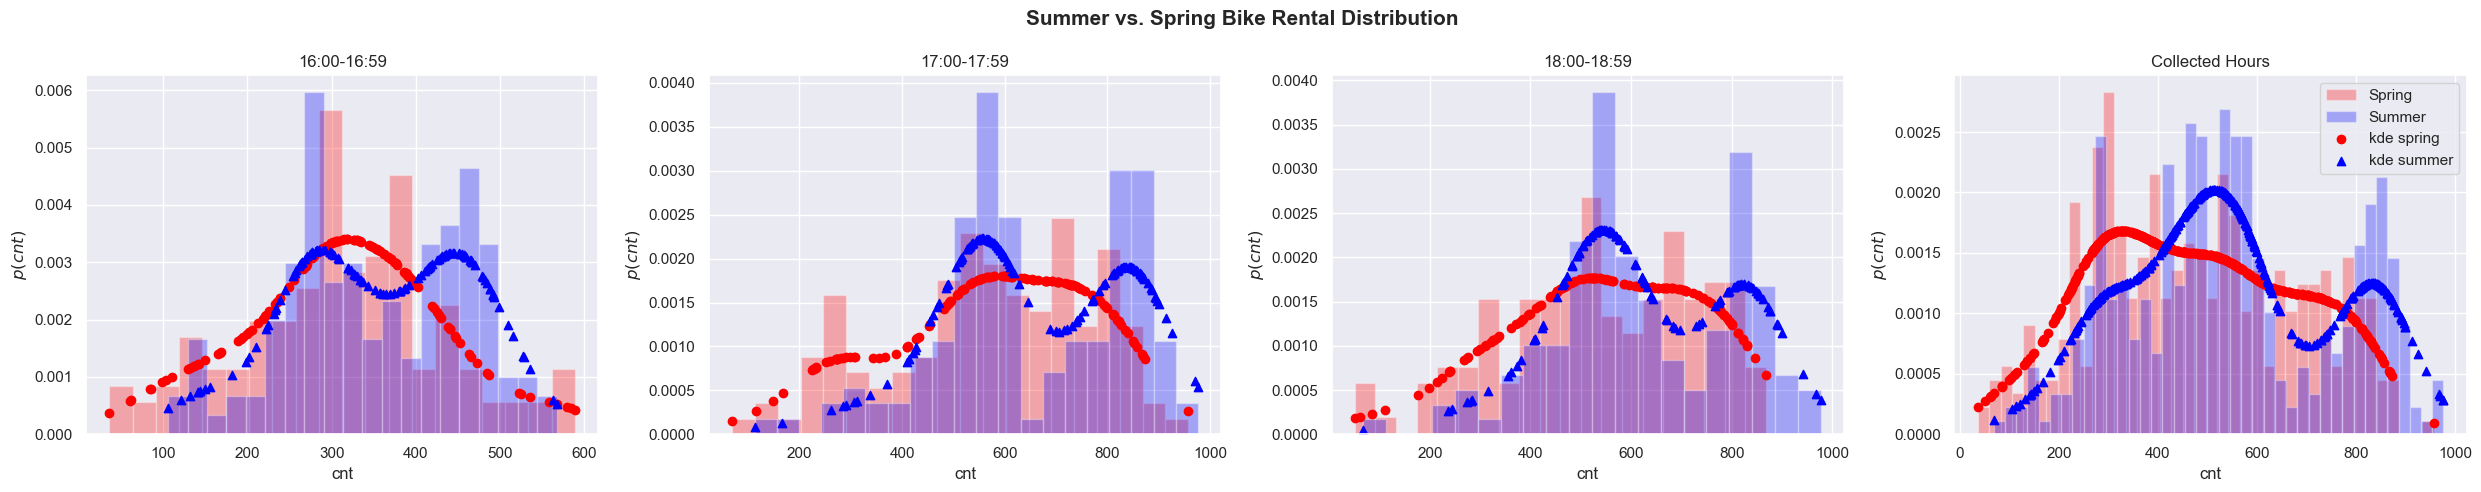

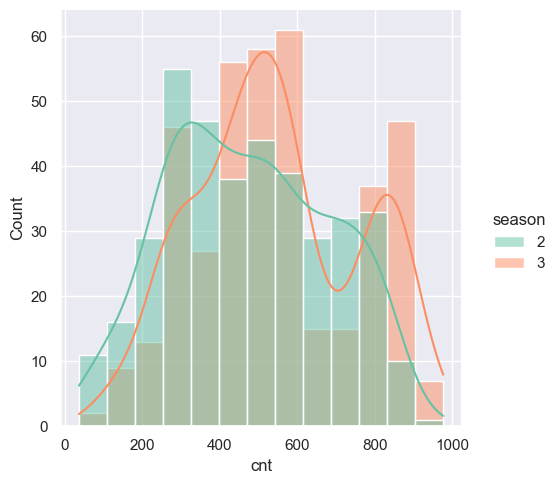

In [253]:
plot_hist_kde(df_agg)

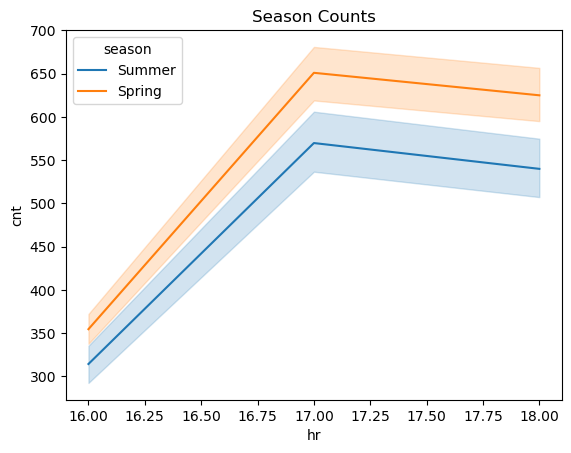

In [ ]:
plot_line(df_agg)

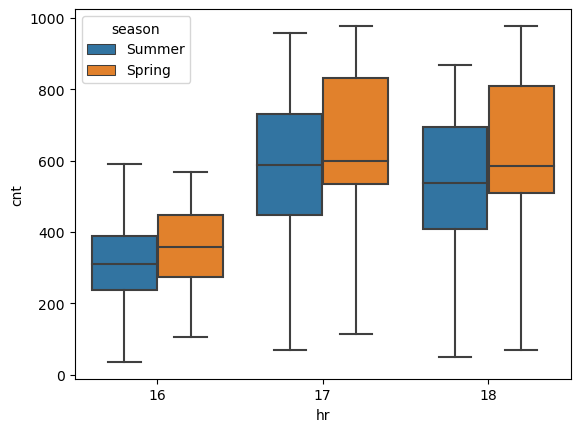

In [209]:
plot_box(df_agg)

Justifies iid assumption under collective hours as a pool (exchangeability when aggregated hours)

# Shapiro-Wilk Test
inspired by https://math.mit.edu/~rmd/465/shapiro.pdf

In [181]:
def norm_expectation_rank(r, n):
    """ 
    
    """
    inf, phi, Phi = float('inf'), stat.NormalDist().pdf, stat.NormalDist().cdf
    def f(x):

        F = Phi(x)
        return x*(1-F)**(r-1)*F**(n-r)*phi(x)
    return r*binom(n, r)*quad(f, -inf, inf)[0]

def expected_val_arr(arr, dict_return=False):
    n = len(arr)
    if not dict_return:
        return np.array([norm_expectation_rank(k+1, n+1) for k in range(n)])
    else:
        return {f"expected val rank {k+1}" : norm_expectation_rank(k+1, n+1) for k in range(n)}

def cov_matrix(arr):
    n = len(arr)
    # TODO confirm covariance matrix
    # see https://apps.dtic.mil/dtic/tr/fulltext/u2/a053857.pdf
    # this requires a tedious implementation which I don't consider worthwhile
    
    return np.eye(N=len(arr), M=len(arr))

def test_statistic(seasons):
    for key in seasons.keys():
        
        x = np.array(seasons[key])
        # normalize
        x = (x - np.mean(x))/ np.std(x)
        x.sort()
        
        assert(np.isclose(np.mean(x), 0))
        assert(np.isclose(np.std(x), 1))

        n = len(x)
        # TODO inspect correctness in this function
        m = expected_val_arr(x)
        
        # Covariance matrix is incorrect, need to investigate how to calculate.
        # see TODO under function
        V = cov_matrix(m)
        
        assert(V[i][j] == V[j][i] for i in range(n) for j in range(n))
        
        normalizing_const = np.sqrt(m.T @ np.linalg.inv(V) @ np.linalg.inv(V) @ m)
        
        a = m.T @ np.linalg.inv(V) / normalizing_const
        W = (x @ a)**2 / np.sum( (x - np.mean(x))**2 )
        
        print(str.capitalize(key))
        print("Sum a: ", np.sum(a))
        print("Sum m: ", np.sum(m))
        print(f"Lower bound = {(n*(a[0]**2))/(n+1)}")
        print(f"Wilk test statistic = {W}\n")

for hr in [16,17,18,19]:
    test = df_agg[df_agg['hr'] == hr]
    print(f"Hour = {hr}")
    filtered_seasons = collect_data(test)
    test_statistic(filtered_seasons)


Hour = 16
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.9770968210121826

Summer
Sum a:  0.23533213574797163
Sum m:  2.605274439525246
Lower bound = 0.05496165946331171
Wilk test statistic = 0.9524844136198254

Hour = 17
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.9770968210121826

Summer
Sum a:  0.23533213574797163
Sum m:  2.605274439525246
Lower bound = 0.05496165946331171
Wilk test statistic = 0.9524844136198254

Hour = 18
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.9770968210121826

Summer
Sum a:  0.23533213574797163
Sum m:  2.605274439525246
Lower bound = 0.05496165946331171
Wilk test statistic = 0.9524844136198254

Hour = 19
Spring
Sum a:  0.23750169992682946
Sum m:  2.5973010263361553
Lower bound = 0.055969793456754444
Wilk test statistic = 0.97709682101

# Kolmogorov-Smirnov Test
inspired by http://www.math.utah.edu/~davar/ps-pdf-files/Kolmogorov-Smirnov.pdf 

The Kolmogorov–Smirnov (KS) test analyze whether two underlying probability distributions differ in the terms of all characteristics of a distribution including location, dispersion and shape. There is no other assumptions about the underlying distributions because the distribution of test statistic is independent of sample distribution. For the problem of comparing the difference in bike hires during two seasons, the bike hires in spring $f_{1,n}(x)$ and that in summer $f_{2,m}(x)$ are samples of two underlying probability density function $f_1(x)$ and $f_2(x)$, and the null hypothesis is that $H_0:f_1(x)=f_2(x)$ $(-\infty \leq x \leq +\infty)$ \cite{young1977proof}. The alternative hypothesis is that $H_1:f_1(x) \neq f_2(x)$ $(-\infty \leq x \leq +\infty)$. The significant level of .05 ($ \alpha = 95\% $) is adopted in our analysis. Let $F_{1,n}(x)$ and $F_{2,m}(x)$ be the empirical distribution function for the bike hire data during spring and summer ($F_n(x)=\frac{number\ of\ (elements\ in\ the\ sample\ \leq \ x)}{n}$). 

The test statistic $D$ for KS test is simply the maximum vertical distance between two empirical distribution functions\cite{berger2014kolmogorov, lanzante2021testing}, 
$$D=\sup_{x} |F_{1,n}(x)-F_{2,m}(x)|$$
Based on a two-tailed test, testing of the null hypothesis proceeds by comparison of p-value against the level of test. In our cases, it gives a $D$ value of 0.5609 and $p-value = 1.9e-18$. Because $pvalue < \frac{1}{2} (1-\alpha) = 0,025$, we may reject the null hypothesis that the the distribution of bike usage during spring and summer is same at the 95\% confident level. In general, KS test is more sensitive to deviations near the center of the distribution than the tails \cite{lanzante2021testing}.


In [121]:
for s in [2,3]:
    test = df_agg[df_agg['season'] == s]
    print(f"Season = {s}")
    filtered_seasons = collect_data(test)
    #print(scipy.stats.mannwhitneyu(filtered_seasons['spring'], filtered_seasons['summer']))
    print(scipy.stats.kstest(filtered_seasons['spring'], filtered_seasons['summer']))
    

Season = 2
KstestResult(statistic=0.20360209923664122, pvalue=0.007525311926029016)
Season = 3
KstestResult(statistic=0.20360209923664122, pvalue=0.007525311926029016)


In [122]:
import math
def combinations(n, r):
    return math.factorial(n) / ( math.factorial(n-r) * math.factorial(r) )

combinations(259, 131)

4.509444947331175e+76

Total combinations is too large to go through all permutations, so we must approximate (use N= 10,000 - common census in literature)

# Permutation Test

In [123]:
from scipy import stats as st
import statistics as stat

def mean_stat(x, y):
    N = len(x) + len(y)
    p = len(x)/N
    q = len(y)/N
    # gives exact significance level ==> robustness
    assert(0.49 < q < 0.51)
    assert(0.49 < p < 0.51)
    var = np.sqrt( (N/len(x)) * np.var(x) +  (N/len(y)) * np.var(y))

    return np.sqrt( len(x) + len(y) ) * (np.mean(x) - np.mean(y)) / var

def var_stat(x, y):
    N = len(x) + len(y)
  
    var = np.sqrt( (N/len(x)) * np.var(x) +  (N/len(y)) * np.var(y))

    return  np.sqrt( len(x) + len(y) ) * (np.std(x) - np.std(y)) / var

def median_stat(x, y):
    
    N = len(x) + len(y)
    
    var = np.sqrt( (N/len(x)) * np.var(x) +  (N/len(y)) * np.var(y))
    
    return np.sqrt( len(x) + len(y) ) *  (np.median(x) - np.median(y)) / var

In [124]:
def plot_permutation_test(df):
    fig, ax = plt.subplots(2,2, figsize=(10,8))                     
    j = 0
    for s in [2,3]:
        test = df[df['season'] == s]
        filtered_seasons = collect_data(test)
        res1 = st.permutation_test(data=(filtered_seasons['summer'], filtered_seasons['spring']), 
                            statistic=mean_stat,
                            n_resamples=10000,
                            permutation_type='independent',
                            alternative='two-sided'
                            )
        res2 = st.permutation_test(data=(filtered_seasons['summer'], filtered_seasons['spring']), 
                            statistic=var_stat,
                            n_resamples=10000,
                            permutation_type='independent',
                            alternative='two-sided'
                            )

        ax[0][j].hist(res1.null_distribution, bins=150, label='$H_{0}$ distribution')
        ax[0][j].axvline(x=res1.statistic, color = "red", linestyle='--', label='Test statistic')
        ax[0][j].set_title(f'$\mu$ = {round(res1.pvalue, 5)}, T = {round(res1.statistic,6)}')
        
        ax[1][j].hist(res2.null_distribution, bins=150, label='$H_{0}$ distribution')
        ax[1][j].axvline(x=res2.statistic, color = "red", linestyle='--',label='Test statistic')
        ax[1][j].set_title(f'$\sigma$ = {round(res2.pvalue,5)}, T = {round(res2.statistic,6)}')
        j +=1
    plt.suptitle(f'Permutation Test', fontsize=15, fontweight='bold')
    plt.legend(loc='best')
    plt.show()

# Permutation Test

The idea behind the permutation test is to generate a test statistic from the data to determine differences between two groups that do not have a distribution that can be deduced. Let $Z = \{Z_{1},\dots,Z_{N}\}$ = $\{X_{1},\dots,X_{m},Y_{1},\dots,Y_{n}\}$ denote the pooled values from spring and summer. In our case, $n = 128 \text{ and } m = 131 \Rightarrow N = 259$, giving $259 \choose 128$ possible combinations. We approximate by sampling two sets of size $n$ and $m$ from $D \subset \pi$, where $\pi$ is the set of all permutations and $|D|=10,000$. We define the test statistic 
   $$T_{m,n}(Z) = \frac{|\bar{\theta_{x}} - \bar{\theta_{y}}|}{\hat{v_{m,n}}}$$
where $\bar{\theta_{x}}$ and $\bar{\theta_{y}}$ are the comparison summary statistics between spring and summer. We compute 
$T_{m,n}(d) \text{ } \forall d \in D$. Letting $T^{1}_{m,n} \leq T^{2}_{m,n} \dots \leq T^{|D|}_{m,n}$ be the ordered values of our samples and setting $\alpha = 0.05$. Let 
$k = |D|-[\alpha{|D|}]$. Then, we have
$$H_0: T_{m,n}(Z) = T_{m,n}(k) \Leftrightarrow | \frac{\bar{\theta_{x}} - \bar{\theta_{y}}|}{\hat{v_{m,n}}} = \frac{|\bar{\theta^{k}_{x}} - \bar{\theta^{k}_{y}}|}{\hat{v^{k}_{m,n}}}$$  
$$H_1: T_{m,n}(Z) \neq T_{m,n}(k)\Leftrightarrow \frac{| \bar{\theta_{x}} - \bar{\theta_{y}}|}{\hat{v_{m,n}}} \neq \frac{|\bar{\theta^{k}_{x}} - \bar{\theta^{k}_{y}}|}{\hat{v^{k}_{m,n}}}$$
where v is found in \cite{perm_test2013}. Under the null we are making two assumptions. First, we assume that all $X$ and all $Y$ for spring and summer are $i.i.d.$, respectively. Further, we assume exchangeability under the null. In words, it means any joint distribution of a permuted sample comes from the same joint distribution as the original sample. However, the variance can pose a challenge to that assumption. Luckily, we can control the level $\alpha$ for any order statistic comparison between the two distributions as our proportion is $\approx \frac{1}{2}$ \cite{perm_test2013}\footnote{ Ref. Theorem 2.1, 2.2 and Ch. 2}. Also, separate observations are remarkably insensitive to the variance criterion under non-normality when the observations come from the same non-normal parent distribution (see histogram above)\cite{perm_theory1955}. That allows us for a controlled test for mean and variance of the two distributions. For a signficance level $\alpha = 0.05$ we get p-values $\in [0.0002,0.0006] \text{ and }  \sigma \in [0.29,0.3208]$ such that we reject the null that $\mu_{X} = \mu_{Y}$ and fail to reject the null for $\sigma_{X} = \sigma_{Y}$
  

Issues to address:
* independence between samples in sets and between sets(weather conditions from day to day, year to year)
* potential loss of power (investigate)
* Type I error and Type II error
* strengths:
* weaknesses:
* comparison to other tests

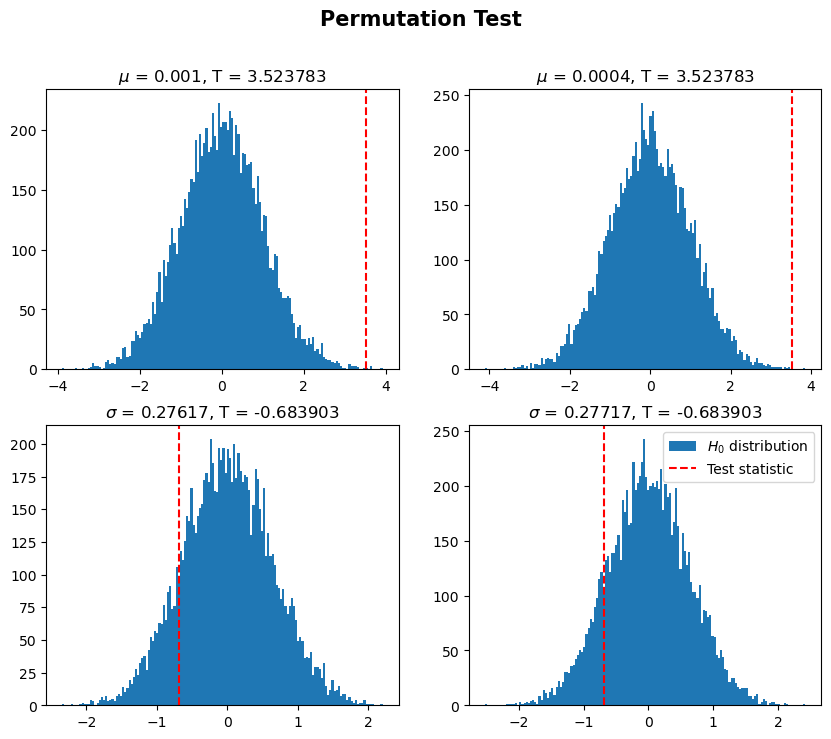

In [125]:
plot_permutation_test(df_agg)